# Test on Controllability and Robustness in Knowledge Graph

- First "pretrain" on pure facts (context length/number of context examples 0) 
- Then "finetune" on 1/3 facts, 1/3 counterfactual, 1/3 robustness (context length ranges from 1 to 3 randomly)
- Test on counterfactual w/ context length 1,2,3, robustness w/ context length 1,2,3

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [2]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers


## Config

In [3]:
args = argparse.Namespace(
    batch_size=32, n_epochs=40, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=2, n_heads=4, d_model=128, dff=None)

In [4]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Load Data

In [5]:
# how to load data and createe data loader
from data_utils import LanguageModelTensorDataset
train_ds_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds.pt')
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)


In [6]:
# create vocab
n_nodes = 50
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_map = {word: idx for idx, word in enumerate(vocab)}

In [7]:
# some examples from train__ds_tensor
for x in train_ds_tensor:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    break

[55, 56, 58, 4, 51, 32, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N4 R1 N32 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [8]:
# some examples from train_dl
train_iter = iter(train_dl)
for _ in range(5):
    # get next from train_dl
    x, y = next(train_iter)
    x, y = x.squeeze(), y.squeeze()
    print('INPUT')
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print('TARGET')
    print(y.tolist())
    print(' '.join([vocab[idx] for idx in y]))
    print('-'*100)
    print()

INPUT
[55, 56, 58, 14, 54, 47, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N14 R4 N47 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
TARGET
[56, 58, 14, 54, 47, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
</CTX> <QUERY> N14 R4 N47 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[55, 56, 58, 35, 53, 31, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N35 R3 N31 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
TARGET
[56, 58, 35, 53, 31, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
</CTX> <QUERY> N35 R3 N31 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[55,

### Create Val and Test Dataset & DataLoader

In [9]:
vocab_map = {vocab: i for i, vocab in enumerate(vocab)}
vocab_size = len(vocab)
print('vocab size: ', vocab_size) 
seq_len = len(train_ds_tensor[0])
print('seq_len: ', seq_len)

# load data and createe data loader

# training set
from data_utils import LanguageModelTensorDataset
train_ds_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds.pt')
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, num_workers=7)


# pretraining set
train_ds_fact_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds_fact.pt')
train_ds_fact = LanguageModelTensorDataset(train_ds_fact_tensor)
train_dl_fact = torch.utils.data.DataLoader(train_ds_fact, batch_size=args.batch_size, shuffle=True, num_workers=7)
train_dl_fact_test_x = train_ds_fact_tensor[:,:5]
train_dl_fact_test_y = train_ds_fact_tensor[:,5:]
train_ds_fact_test = torch.utils.data.TensorDataset(train_dl_fact_test_x, train_dl_fact_test_y)
train_dl_fact_test = torch.utils.data.DataLoader(train_ds_fact_test, batch_size=args.batch_size, shuffle=True, num_workers=7)

test_ds_tensor_control_1 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_controllability_1.pt')
test_ds_control_1 = LanguageModelTensorDataset(test_ds_tensor_control_1)
test_dl_control_1_val = torch.utils.data.DataLoader(test_ds_control_1, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_control_1_test_x = test_ds_tensor_control_1[:,:9]
test_ds_control_1_test_y = test_ds_tensor_control_1[:,9:]
test_ds_control_1_test = torch.utils.data.TensorDataset(test_ds_control_1_test_x, test_ds_control_1_test_y)
test_dl_control_1 = torch.utils.data.DataLoader(test_ds_control_1_test, batch_size=args.batch_size, shuffle=False, num_workers=7)

test_ds_tensor_control_2 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_controllability_2.pt')
test_ds_control_2 = LanguageModelTensorDataset(test_ds_tensor_control_2)
test_dl_control_2_val = torch.utils.data.DataLoader(test_ds_control_2, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_control_2_test_x = test_ds_tensor_control_2[:,:13]
test_ds_control_2_test_y = test_ds_tensor_control_2[:,13:]
test_ds_control_2_test = torch.utils.data.TensorDataset(test_ds_control_2_test_x, test_ds_control_2_test_y)
test_dl_control_2 = torch.utils.data.DataLoader(test_ds_control_2_test, batch_size=args.batch_size, shuffle=False, num_workers=7)


test_ds_tensor_control_3 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_controllability_3.pt')
test_ds_control_3 = LanguageModelTensorDataset(test_ds_tensor_control_3)
test_dl_control_3_val = torch.utils.data.DataLoader(test_ds_control_3, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_control_3_test_x = test_ds_tensor_control_3[:,:17]
test_ds_control_3_test_y = test_ds_tensor_control_3[:,17:]
test_ds_control_3_test = torch.utils.data.TensorDataset(test_ds_control_3_test_x, test_ds_control_3_test_y)
test_dl_control_3 = torch.utils.data.DataLoader(test_ds_control_3_test, batch_size=args.batch_size, shuffle=False, num_workers=7)


test_ds_tensor_robust_1 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_robustness_1.pt')
test_ds_robust_1 = LanguageModelTensorDataset(test_ds_tensor_robust_1)
test_dl_robust_1_val = torch.utils.data.DataLoader(test_ds_robust_1, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_robust_1_test_x = test_ds_tensor_robust_1[:,:9]
test_ds_robust_1_test_y = test_ds_tensor_robust_1[:,9:]
test_ds_robust_1_test = torch.utils.data.TensorDataset(test_ds_robust_1_test_x, test_ds_robust_1_test_y)
test_dl_robust_1 = torch.utils.data.DataLoader(test_ds_robust_1_test, batch_size=args.batch_size, shuffle=False, num_workers=7)


test_ds_tensor_robust_2 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_robustness_2.pt')
test_ds_robust_2 = LanguageModelTensorDataset(test_ds_tensor_robust_2)
test_dl_robust_2_val = torch.utils.data.DataLoader(test_ds_robust_2, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_robust_2_test_x = test_ds_tensor_robust_2[:,:13]
test_ds_robust_2_test_y = test_ds_tensor_robust_2[:,13:]
test_ds_robust_2_test = torch.utils.data.TensorDataset(test_ds_robust_2_test_x, test_ds_robust_2_test_y)
test_dl_robust_2 = torch.utils.data.DataLoader(test_ds_robust_2_test, batch_size=args.batch_size, shuffle=False, num_workers=7)




test_ds_tensor_robust_3 = torch.load('../data/knowledge_graph/knowledge_graph_val_ds_robustness_3.pt')
test_ds_robust_3 = LanguageModelTensorDataset(test_ds_tensor_robust_3)
test_dl_robust_3_val = torch.utils.data.DataLoader(test_ds_robust_3, batch_size=args.batch_size, shuffle=False)
test_ds_robust_3_test_x = test_ds_tensor_robust_3[:,:17]
test_ds_robust_3_test_y = test_ds_tensor_robust_3[:,17:]
test_ds_robust_3_test = torch.utils.data.TensorDataset(test_ds_robust_3_test_x, test_ds_robust_3_test_y)
test_dl_robust_3 = torch.utils.data.DataLoader(test_ds_robust_3_test, batch_size=args.batch_size, shuffle=False)


print("Number of batches: ", len(train_dl))
    

vocab size:  63
seq_len:  20
Number of batches:  94


## Model

In [10]:
import lightning as L
import matplotlib.pyplot as plt
from collections import defaultdict

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.train_dl = train_dl
        self.mismatched_sequences = []
        self.all_seq_acc = []
        self.all_per_pos_acc = []
        self.facts_loader = train_dl_fact_test
        self.truth = []
        self.val_pred_mistakes_reason_batch = defaultdict(lambda: defaultdict(list))
        self.val_pred_mistakes_reason = defaultdict(lambda: defaultdict(list))
        # store (sub,rel,obj) tuples from the truth in the training set
        self.truth_extract()
        self.context_tuples_mixture_train = self.context_extract(self.train_dl)
        self.query_tuples_mixture_train = self.query_extract(self.train_dl)
        self.reasons = ["own_context_ro", "other_context_train_dl_sro", "query_sro", "query_ro", 'fact']


    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)
        pred = torch.argmax(logits, dim=-1)
        # accuracy. torch.where(y==<QUERY>) and find relevant pred_idx accordingly (index add 3)
        query_idx = vocab_map['<QUERY>']
        pred_idx = torch.where(y[0]==query_idx)[0] + 3
        acc = torch.mean((pred[:,pred_idx] == y[:,pred_idx]).float())
        
        
        # TODO: compute cross-entropy with ignore_idx=padd_token_idx
        # TODO: compute perplexity with ignore_idx=padd_token_idx
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)
        self.log('train_obj_acc', acc, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        # x, y = batch
        # # with ctx:
        # logits, loss = self.model(x, y)
        

        # perplexity = torchmetrics.functional.text.perplexity(logits, y)
        # self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=True)
        # self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=True)
        x, y = batch
        # Generate predictions using the generate function, return the entire sequence
        predicted_idx = self.model.generate(x, max_new_tokens=y.size(1), top_k=1)
        generated_seq = predicted_idx[:, x.size(1):]
        
        self.capture_mismatches(generated_seq,y, x)
        # val_dataloader = self.trainer.val_dataloaders[dataloader_idx]
        fact_affected_prediction = self.fact_affected_prediction()
        if fact_affected_prediction != None:
            # non empty mismatched seq
            self.val_pred_mistakes_reason_batch[dataloader_idx]['fact'].append(fact_affected_prediction)
        other_reasons = self.context_affected_prediction()
        if other_reasons != None:
            for i in range(len(other_reasons)):
                self.val_pred_mistakes_reason_batch[dataloader_idx][self.reasons[i]].append(other_reasons[i])
        self.mismatched_sequences.clear()
        
        
        

    def test_step(self, batch, batch_idx, dataloader_idx=0):

        x, y = batch
        # Generate predictions using the generate function, return the entire sequence
        predicted_idx = self.model.generate(x, max_new_tokens=y.size(1), top_k=1)
        generated_seq = predicted_idx[:, x.size(1):]
    
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(generated_seq, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(generated_seq, y)
        
        # Store metrics for later averaging
        self.all_seq_acc.append(seq_acc)
        self.all_per_pos_acc.append(per_pos_acc)
        
        self.capture_mismatches(generated_seq,y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, preds, targets):
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)

    

    def truth_extract(self):
        """
        Extracts the truth values for the given object and relation in testing sets.
        """
        
        for i, batch_i_data in enumerate(self.facts_loader): 
            x,y = batch_i_data
            for j in range(x.size(0)):
                sub = x[j,-2]
                rel = x[j,-1]
                obj = y[j,0]
                self.truth.append((sub, rel, obj))
                

    def fact_affected_prediction(self):
        if not self.mismatched_sequences:
            return None
        counter = 0
        for mismatch in self.mismatched_sequences:
            input_seq = mismatch['input']
            predicted_seq = mismatch['predicted']
            target_seq = mismatch['target']
            
            # find the object and relation in the input sequence
        
            for i in range(len(input_seq)):
                # print(i, input_seq[i])
                if input_seq[i] == vocab_map['<QUERY>']:
                    sub = input_seq[i+1]
                    rel = input_seq[i+2]
                    obj_target = target_seq[0]
                    obj_pred = predicted_seq[0]
                    
                    if (sub, rel, obj_pred) in self.truth:
                        counter += 1  
                    break
               
        return counter/len(self.mismatched_sequences)            
    
    def context_extract(self, dataloader):
        context_tuples_mixture_train =[]
        for x, y in dataloader:
            for i in range(x.size(0)):
                for j in range(x.size(1)):
                    if x[i,j] == vocab_map['<CTX>']:
                        context_tuples_mixture_train.append(x[i,j+1: j+4])
                    elif x[i,j] == vocab_map['<SEP>'] and x[i,j+1] != vocab_map['</CTX>']:    
                        context_tuples_mixture_train.append(x[i,j+1: j+4])
                    elif x[i,j] == vocab_map['</CTX>']:
                        break
        return context_tuples_mixture_train


    def query_extract(self, dataloader):
        query_tuples_mixture_train =[]
        for x, y in dataloader:
            for i in range(x.size(0)):
                for j in range(x.size(1)):
                    if x[i,j] == vocab_map['<QUERY>']:
                        query_tuples_mixture_train.append(x[i,j+1: j+4])
                        break
        return query_tuples_mixture_train

    

    def context_affected_prediction(self):
        
        if not self.mismatched_sequences:
            return None
        counter_own_context = 0
        counter_other_context = 0
        counter_query = 0
        counter_query_ro = 0
        for mismatch in self.mismatched_sequences:
            input_seq = mismatch['input']
            predicted_seq = mismatch['predicted']
            target_seq = mismatch['target']
            
            # find the object and relation in the input sequence
            context_examples = []
            for i in range(len(input_seq)):
                # organize examples from context
                if input_seq[i] == vocab_map['<CTX>']:
                    context_examples.append(input_seq[i+1:i+4])
                elif input_seq[i] == vocab_map['<SEP>'] and input_seq[i] != vocab_map['</CTX>']:
                    context_examples.append(input_seq[i+1:i+4])               


                elif input_seq[i] == vocab_map['<QUERY>']:
                    sub = input_seq[i+1]
                    rel = input_seq[i+2]
                    obj_target = target_seq[0]
                    obj_pred = predicted_seq[0]
                    if (sub, rel, obj_pred) in self.context_tuples_mixture_train:
                        #print("affected by some context in mixture training",sub, rel, obj_pred)
                        counter_other_context+=1
                    
                    for (s,r,o) in context_examples:
                        if (r == rel) and (o == obj_pred):
                        #print("affected by its own context",input_seq)   
                            counter_own_context+=1
                            break

                    if (sub, rel, obj_pred) in self.query_tuples_mixture_train:
                        counter_query+=1

                    for (s,r,o) in self.query_tuples_mixture_train:
                        if (r == rel) and (o == obj_pred):
                            counter_query_ro +=1
                            break
                    break
            num_mistakes = len(self.mismatched_sequences)
        return counter_own_context/num_mistakes, counter_other_context/num_mistakes, counter_query/num_mistakes, counter_query_ro/num_mistakes


              
    def on_test_epoch_end(self):
        # Calculate overall metrics from all batches
        if self.all_seq_acc and self.all_per_pos_acc:

            overall_seq_acc = torch.mean(torch.stack(self.all_seq_acc))
            overall_per_pos_acc = torch.mean(torch.stack(self.all_per_pos_acc), dim=0)
            # Log overall metrics
            self.log('test_overall_seq_acc', overall_seq_acc, on_step=False, on_epoch=True)
            self.log('test_overall_per_pos_acc_mean', overall_per_pos_acc.mean(), on_step=False, on_epoch=True)

            # Plot overall per position accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(overall_per_pos_acc.cpu().numpy(), marker='o', linestyle='-')
            plt.title('Overall Per Position Accuracy')
            plt.xlabel('Position')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.show()

            # Clear the accumulators for the next epoch
            self.all_seq_acc = []
            self.all_per_pos_acc = []   
    
    def on_validation_epoch_end(self):
        # Calculate overall metrics from all batches
        for dataloader_idx in self.val_pred_mistakes_reason_batch.keys():
            for reason in self.reasons:
                if self.val_pred_mistakes_reason_batch[dataloader_idx][reason]:
                    overall_affected_prediction = torch.mean(torch.tensor(self.val_pred_mistakes_reason_batch[dataloader_idx][reason]))
                    self.val_pred_mistakes_reason[dataloader_idx][reason].append(overall_affected_prediction)
                    self.val_pred_mistakes_reason_batch[dataloader_idx][reason].clear()
                    
            


    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [11]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True


model_args = dict(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, dff=dff,
    dropout_rate=dropout_rate, activation=activation, norm_first=norm_first, max_block_size=seq_len)
model = TransformerLM(**model_args)#.to(device)
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)

Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
TransformerLM (TransformerLM)                                               --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (token_embedder): 2-1                                      8,064                  1.94%              True
│    │    └─Linear (weights): 3-1                                           8,127                  1.96%              True
│    └─Embedding (positional_embedder): 2-2                                 2,560                  0.62%              True
│    └─Dropout (dropout): 2-3                                               --                        --              --
│    └─ModuleList (blocks): 2-4                                             --                        --              True
│    │    └─E

In [12]:
lit_model = LitLanguageModel(model)

In [13]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=True, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
# multi validation dataloaders
validation_dataloaders = [test_dl_control_1, test_dl_control_2, test_dl_control_3, test_dl_robust_1, test_dl_robust_2, test_dl_robust_3]
with ctx:
    trainer.fit(model=lit_model, train_dataloaders=train_dl_fact)


Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/rw686/.conda/envs/memory/lib/python3.11/site-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning 

num decayed parameter tensors: 11, with 411,904 parameters
num non-decayed parameter tensors: 17, with 3,391 parameters
using fused AdamW: True


Training: |          | 0/? [00:00<?, ?it/s]

/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('train_obj_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
`Trainer.fit` stopped: `max_epochs=40` reached.


In [14]:
# validation set mistake reasons
print(lit_model.val_pred_mistakes_reason)
pred_mistakes_fact_reason_train_w_fact_only = lit_model.val_pred_mistakes_reason


defaultdict(<function LitLanguageModel.__init__.<locals>.<lambda> at 0x14b65097e160>, {})


In [15]:
for (x,y) in train_dl_fact:
    query = x[:, :5]
    ans = x[:, 5]
    pred, _ = model(query)
    pred_idx = torch.argmax(pred, dim=-1).squeeze()
    print(query[0])
    print(ans[0])
    print(pred_idx[0])
    print(x[0][:8])
    acc = torch.mean((ans == pred_idx).float())
    print(acc)
    break

tensor([55, 56, 58, 19, 51])
tensor(45)
tensor(45)
tensor([55, 56, 58, 19, 51, 45, 59])
tensor(1.)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

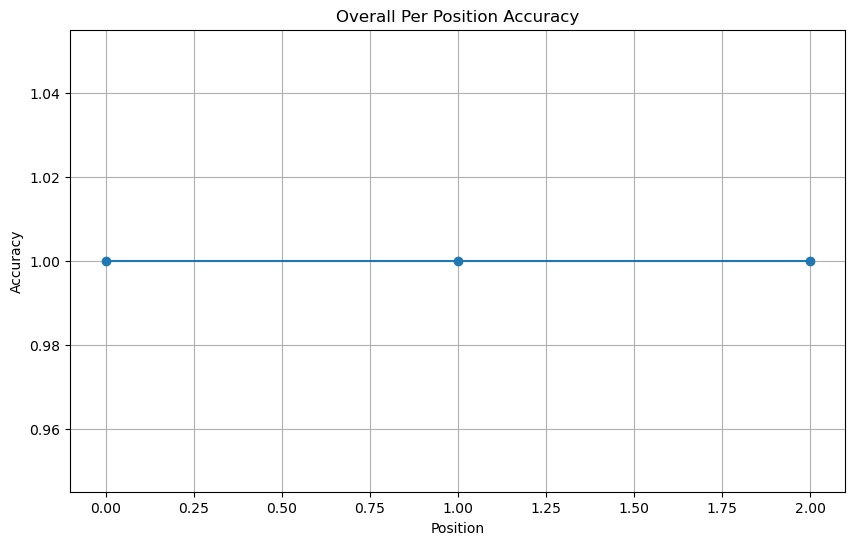

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean             1.0
    test_overall_seq_acc                  1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [16]:
# test on pure fact, make sure it achieves 100% accuracy
trainer.test(model=lit_model, dataloaders=train_dl_fact_test)
reverse_vocab_map = {idx: vocab for vocab, idx in vocab_map.items()}



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |          | 0/? [00:00<?, ?it/s]

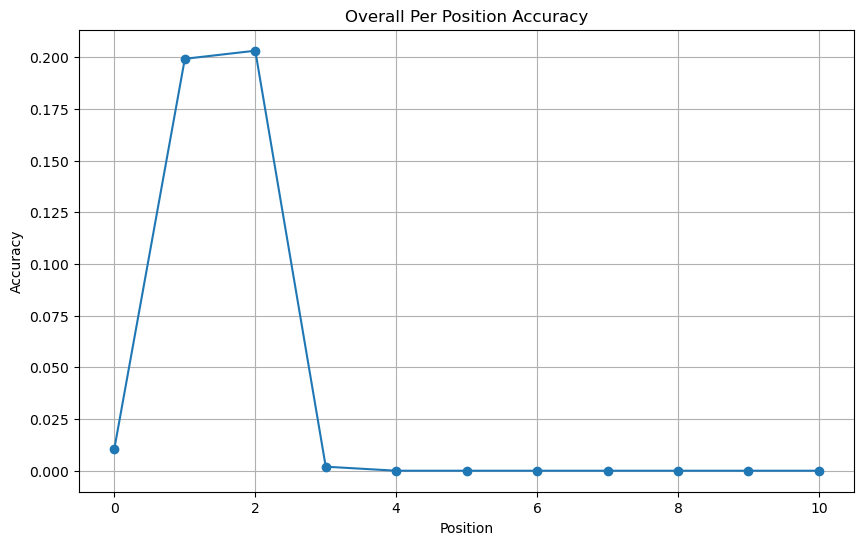

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.03773082420229912
    test_overall_seq_acc                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |          | 0/? [00:00<?, ?it/s]

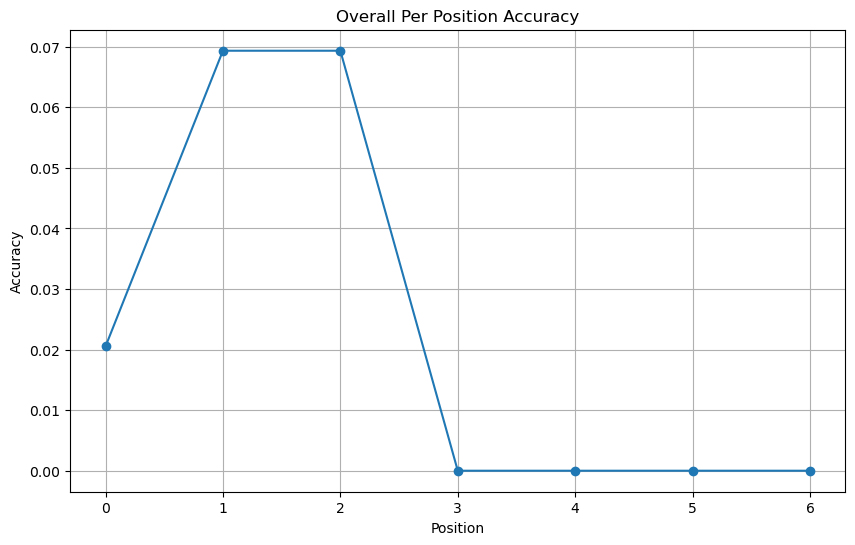

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.02273995615541935
    test_overall_seq_acc                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |          | 0/? [00:00<?, ?it/s]

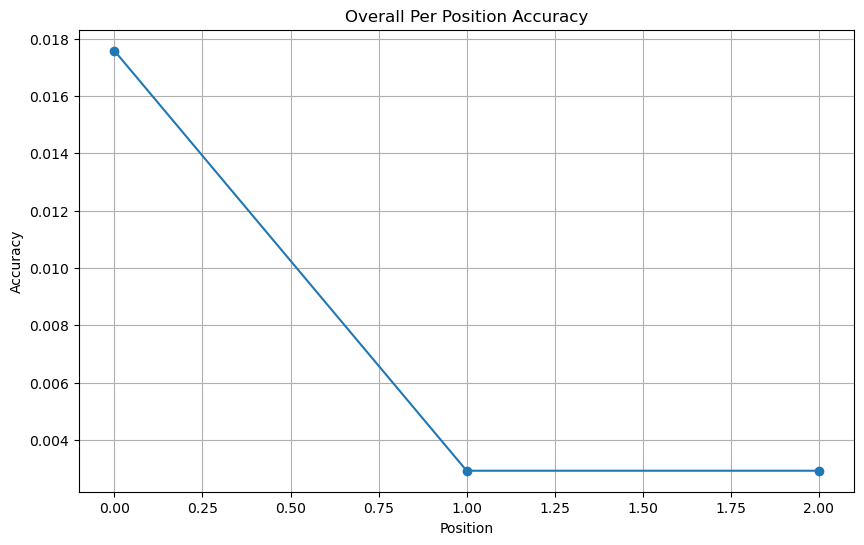

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean          0.0078125
    test_overall_seq_acc                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [17]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_1)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_2)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_3)
lit_model.mismatched_sequences.clear()



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |          | 0/? [00:00<?, ?it/s]

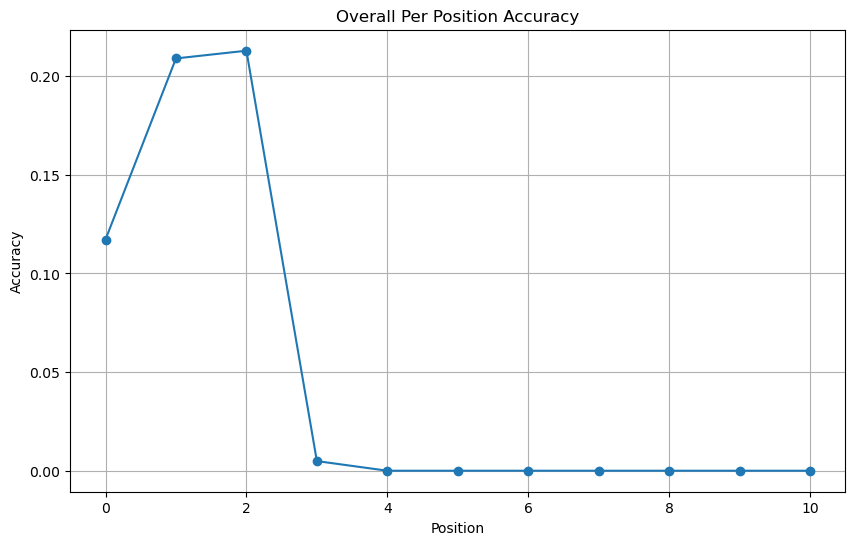

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.04944957420229912
    test_overall_seq_acc                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Testing: |          | 0/? [00:00<?, ?it/s]

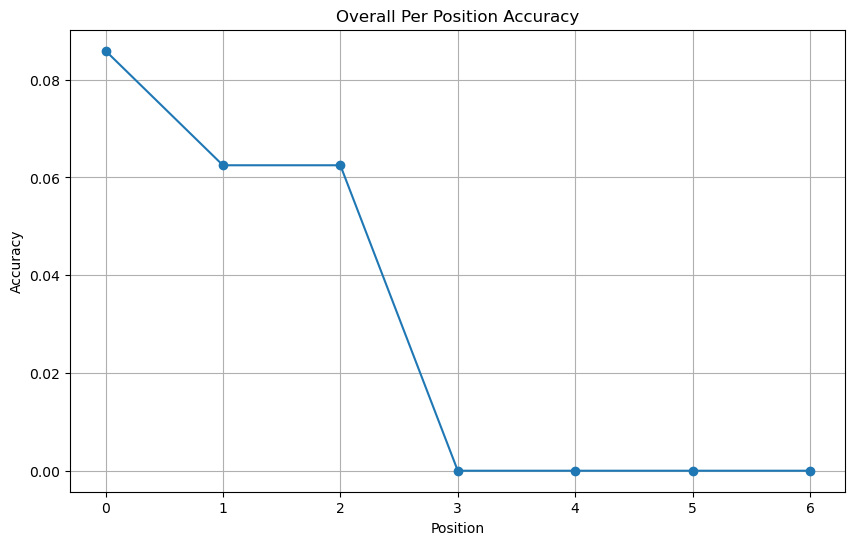

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.0301339291036129
    test_overall_seq_acc                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

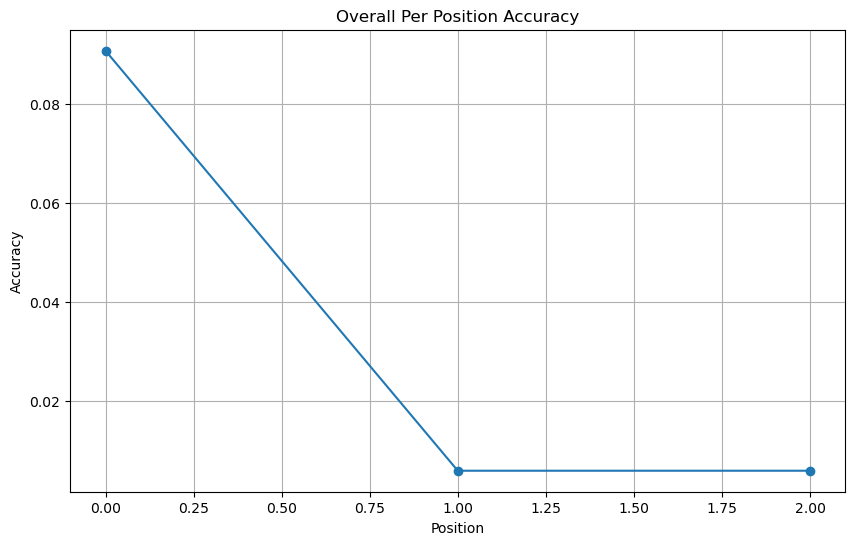

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean        0.0341796875
    test_overall_seq_acc             0.0009765625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [18]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_1)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_2)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_3)
lit_model.mismatched_sequences.clear()


### "finetune" on mixture dataset: 1/3 fact 1/3 counterfactual 1/3 robustness


In [19]:
# finetune on mixture dataset: 1/3 fact 1/3 counterfactual 1/3 robustness

trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=True, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False,
    )

 
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=validation_dataloaders)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 415 K 
----------------------------------------
415 K     Trainable params
0         Non-trainable params
415 K     Total params
1.661     Total estimated model params size (MB)


num decayed parameter tensors: 11, with 411,904 parameters
num non-decayed parameter tensors: 17, with 3,391 parameters
using fused AdamW: True


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |          | 0/? [00:00<?, ?it/s]

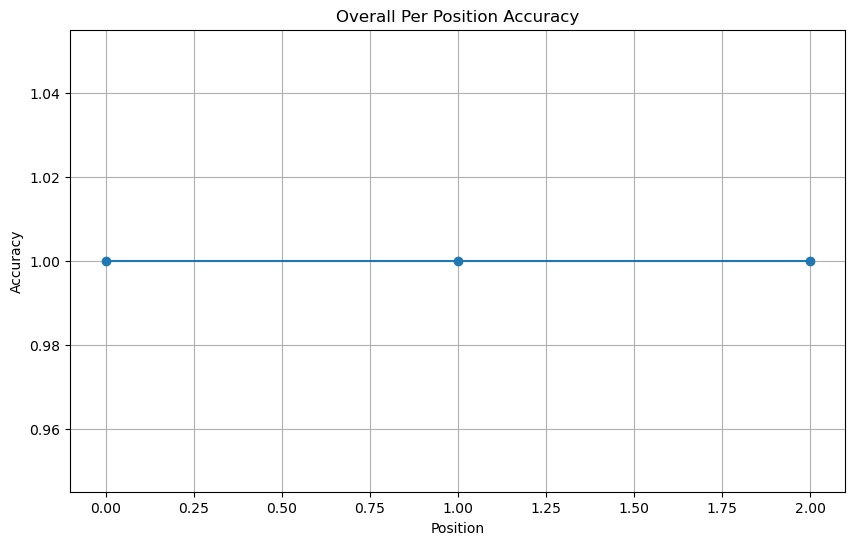

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean             1.0
    test_overall_seq_acc                  1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [20]:
reverse_vocab_map = {i: word for word, i in vocab_map.items()}

# model performance on the pure fact pretraining set
trainer.test(model=lit_model, dataloaders=train_dl_fact_test)
# model performance on the validation set
lit_model.mismatched_sequences.clear()


defaultdict(<function LitLanguageModel.__init__.<locals>.<lambda> at 0x14b65097e160>, {0: defaultdict(<class 'list'>, {'own_context_ro': [tensor(0.0312), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)], 'other_context_train_dl_sro': [tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)

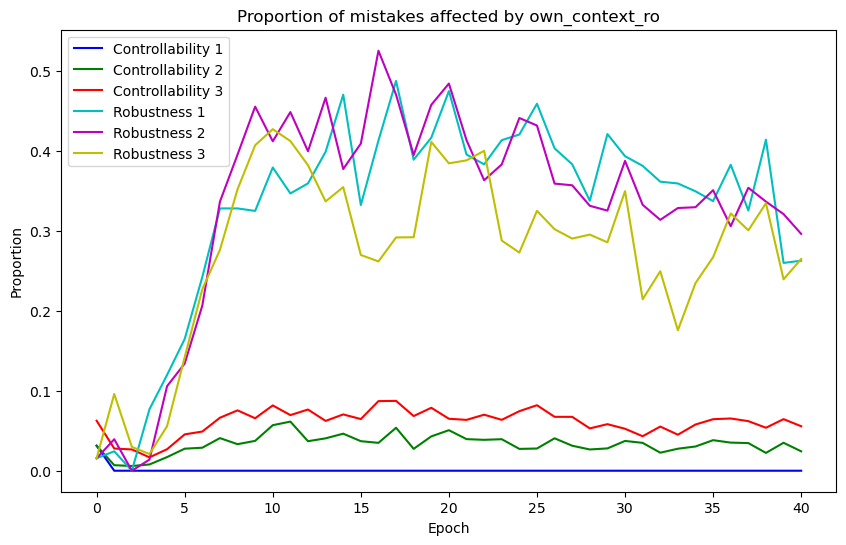

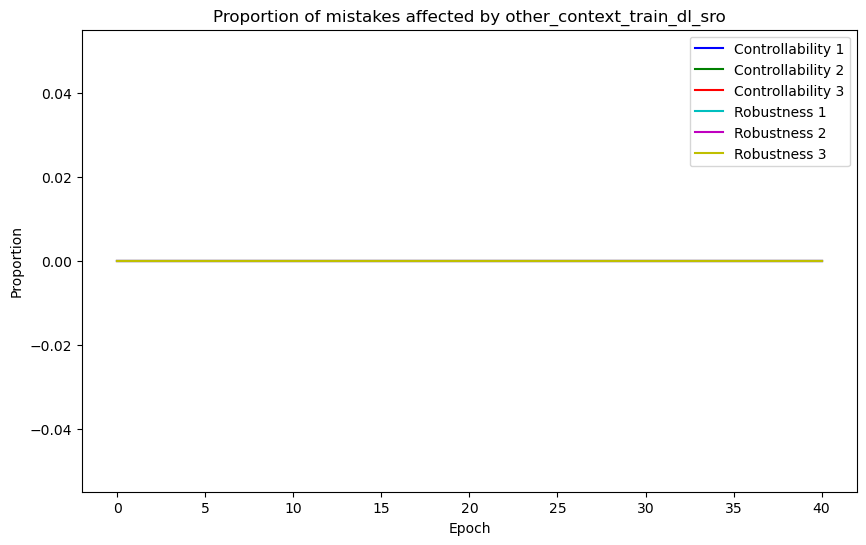

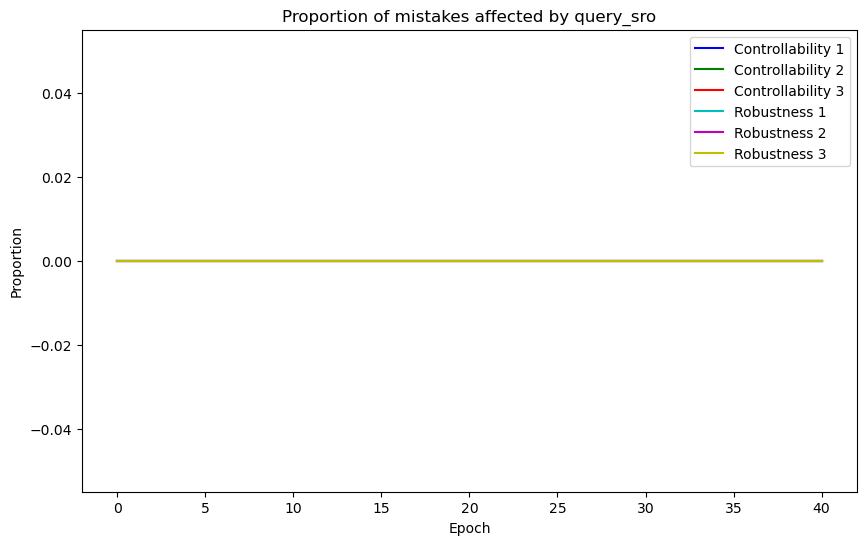

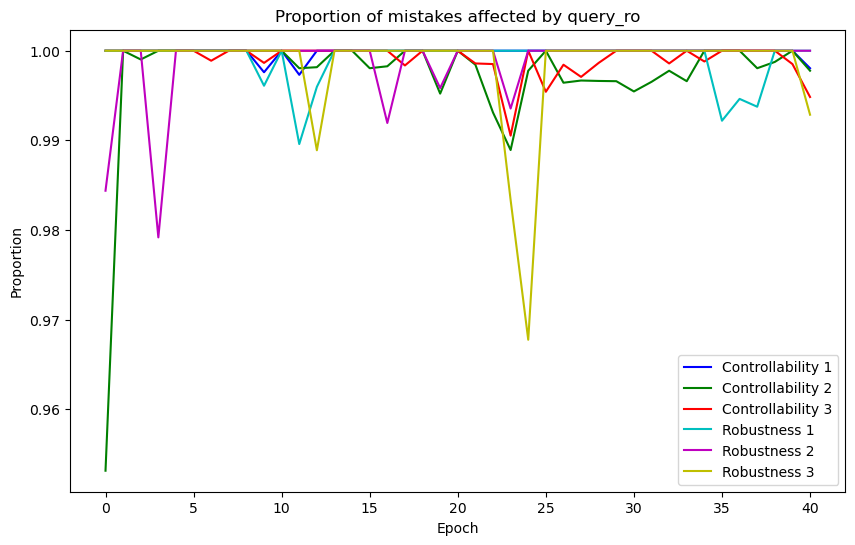

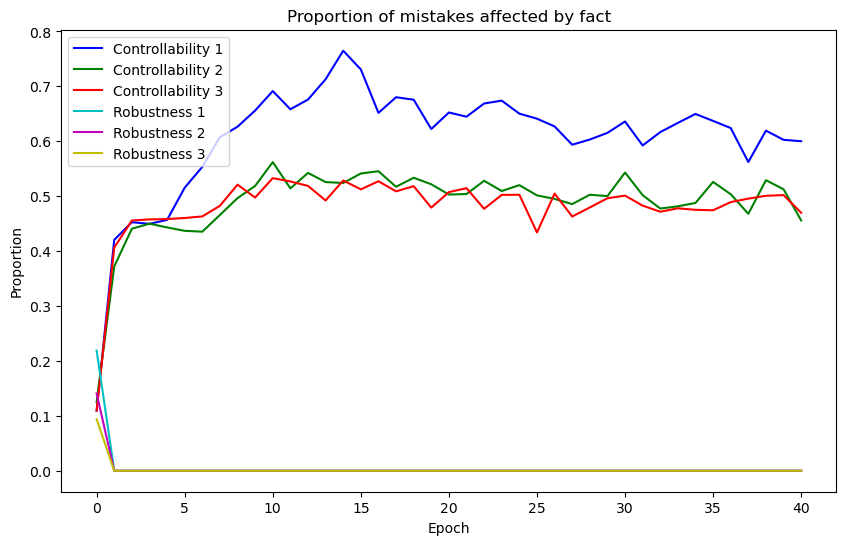

TypeError: Object of type Tensor is not JSON serializable

In [25]:
# validation set mistake reasons
print(lit_model.val_pred_mistakes_reason)
pred_mistakes_fact_reason_train_w_mxiture = lit_model.val_pred_mistakes_reason
# Plot each series with a different color
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  
reasons = pred_mistakes_fact_reason_train_w_mxiture[0].keys()
for reason in reasons:
    plt.figure(figsize=(10, 6))

    for idx, (key, values) in enumerate(pred_mistakes_fact_reason_train_w_mxiture.items()):
        if key <=2:
            dataname = f'Controllability {key+1}'
        else:
            dataname = f'Robustness {key-2}'
        plt.plot(values[reason], label=dataname, color=colors[idx % len(colors)])

    plt.xlabel('Epoch')
    plt.ylabel('Proportion')
    plt.title(f'Proportion of mistakes affected by {reason}')
    plt.legend()
    plt.show()


## Test on counterfactual context

In [ ]:
def decode_sequence(seq, reverse_vocab_map):
    return ' '.join([reverse_vocab_map[idx] for idx in seq])

def mismatch_seq_print(mismatch, reverse_vocab_map, max_examples=3):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}\n")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |          | 0/? [00:00<?, ?it/s]

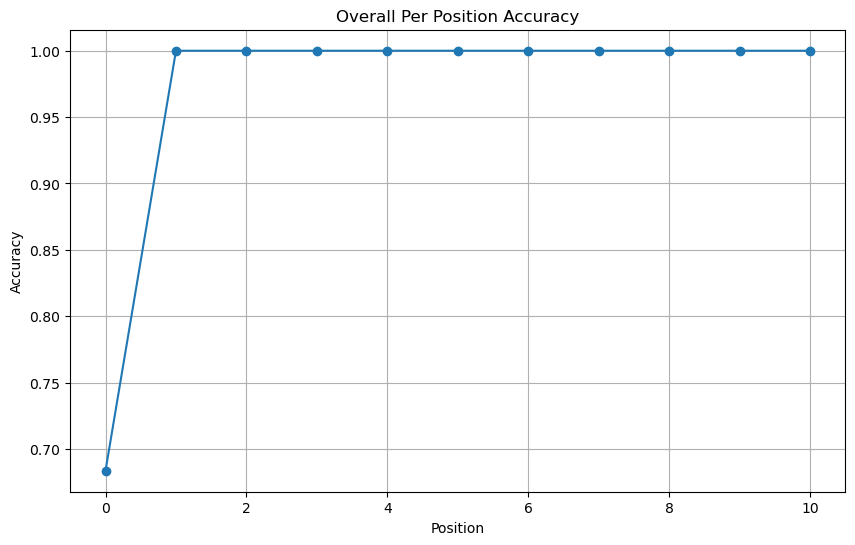

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9712358117103577
    test_overall_seq_acc              0.68359375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N49 R4 N7 <SEP> </CTX> <QUERY> N49 R4
Predicted: N15 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N38 R2 N1 <SEP> </CTX> <QUERY> N38 R2
Predicted: N28 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N1 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N35 R2 N47 <SEP> </CTX> <QUERY> N35 R2
Predicted: N6 </QUERY> <E

Testing: |          | 0/? [00:00<?, ?it/s]

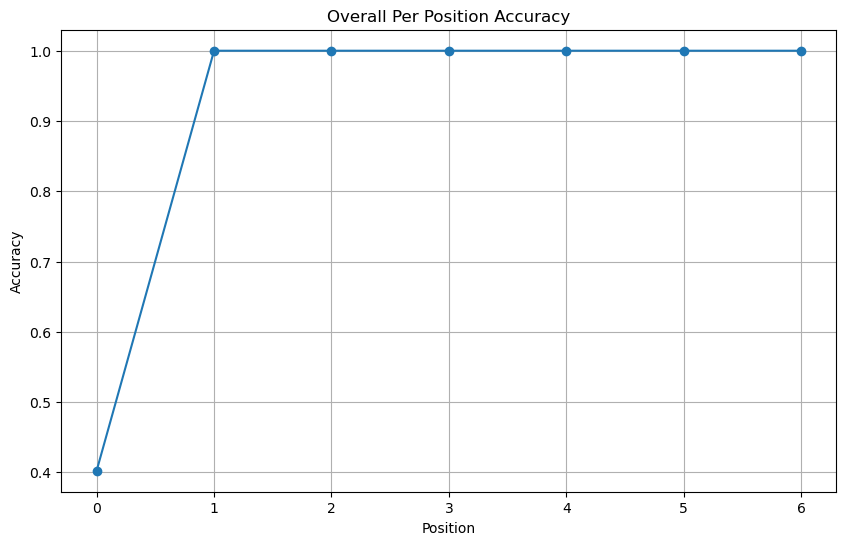

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean      0.914620578289032
    test_overall_seq_acc              0.40234375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N0 R1 N18 <SEP> N4 R4 N3 <SEP> </CTX> <QUERY> N4 R4
Predicted: N46 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N3 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N8 R1 N37 <SEP> N15 R0 N19 <SEP> </CTX> <QUERY> N8 R1
Predicted: N3 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N37 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N2 R0 N27 <SEP> N49 R3 N28 <SEP> </CTX> <QUERY> N2 R0
Predicted: N38 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N27 </QUERY> <

Testing: |          | 0/? [00:00<?, ?it/s]

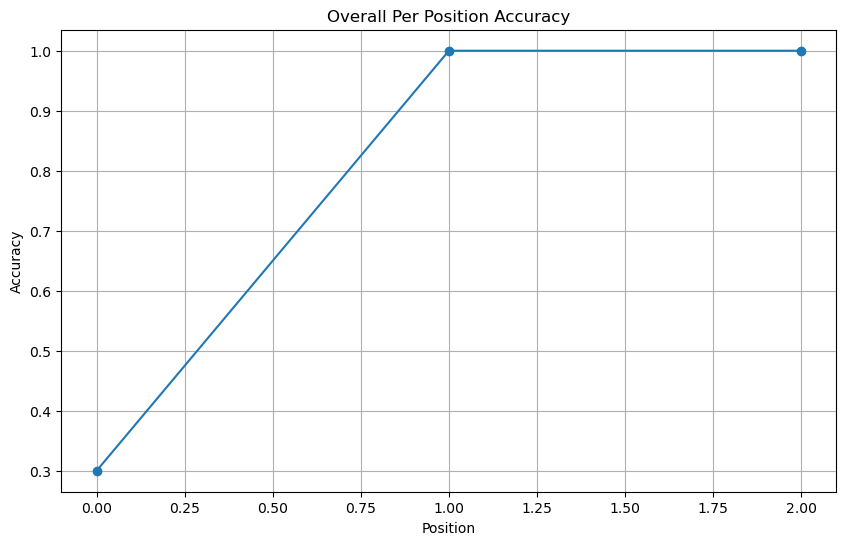

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.7669271230697632
    test_overall_seq_acc              0.30078125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N46 R4 N31 <SEP> N15 R1 N29 <SEP> N42 R3 N22 <SEP> </CTX> <QUERY> N46 R4
Predicted: N28 </QUERY> <EOS>
Target: N31 </QUERY> <EOS>

Input: <CTX> N17 R1 N43 <SEP> N42 R2 N25 <SEP> N26 R4 N28 <SEP> </CTX> <QUERY> N42 R2
Predicted: N2 </QUERY> <EOS>
Target: N25 </QUERY> <EOS>

Input: <CTX> N16 R2 N6 <SEP> N47 R0 N29 <SEP> N24 R3 N23 <SEP> </CTX> <QUERY> N47 R0
Predicted: N13 </QUERY> <EOS>
Target: N29 </QUERY> <EOS>



In [ ]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_1)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_2)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_3)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)




## Test on Robustness 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |          | 0/? [00:00<?, ?it/s]

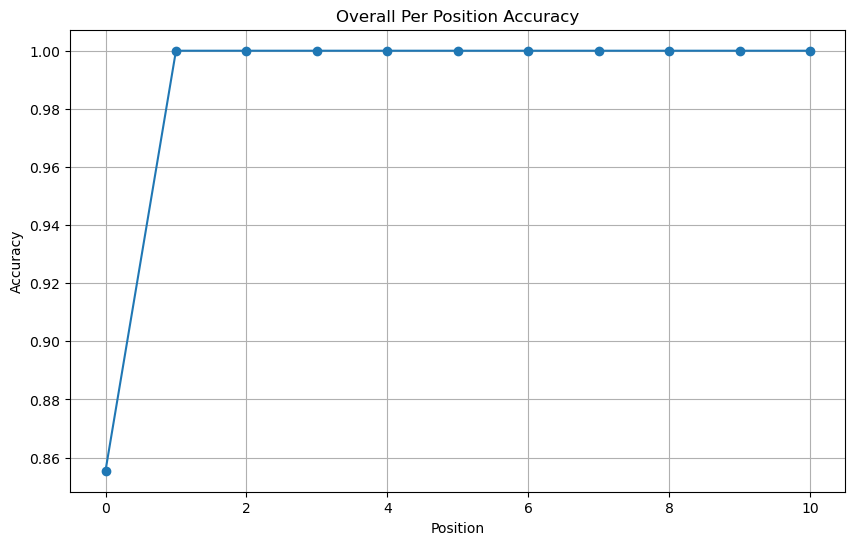

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9868608117103577
    test_overall_seq_acc              0.85546875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N15 R0 N19 <SEP> </CTX> <QUERY> N21 R2
Predicted: N19 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N13 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N6 R0 N7 <SEP> </CTX> <QUERY> N20 R0
Predicted: N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N2 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N20 R1 N39 <SEP> </CTX> <QUERY> N15 R1
Predicted: N12 </QUERY> <

Testing: |          | 0/? [00:00<?, ?it/s]

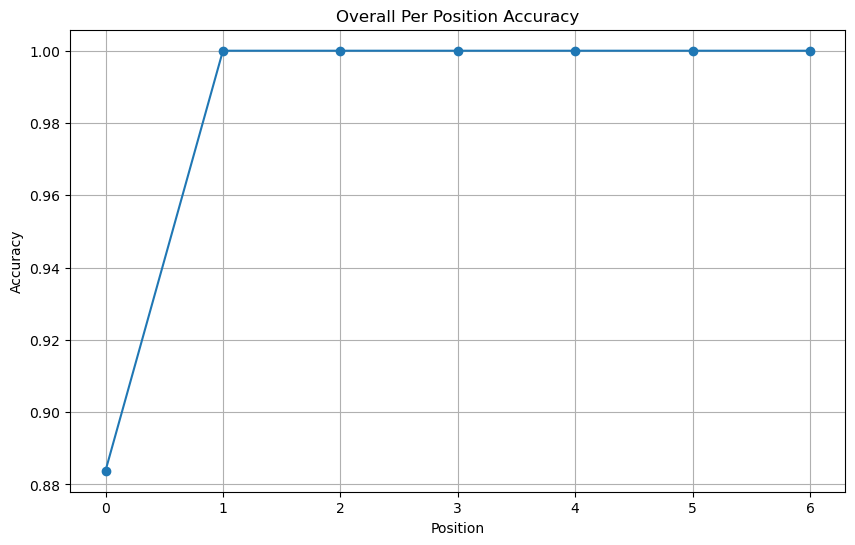

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9833984971046448
    test_overall_seq_acc             0.8837890625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N35 R4 N16 <SEP> N33 R1 N49 <SEP> </CTX> <QUERY> N43 R2
Predicted: N33 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N1 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N36 R2 N12 <SEP> N20 R3 N49 <SEP> </CTX> <QUERY> N42 R3
Predicted: N49 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N22 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N13 R4 N41 <SEP> N23 R4 N41 <SEP> </CTX> <QUERY> N4 R1
Predicted: N41 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N32 <

Testing: |          | 0/? [00:00<?, ?it/s]

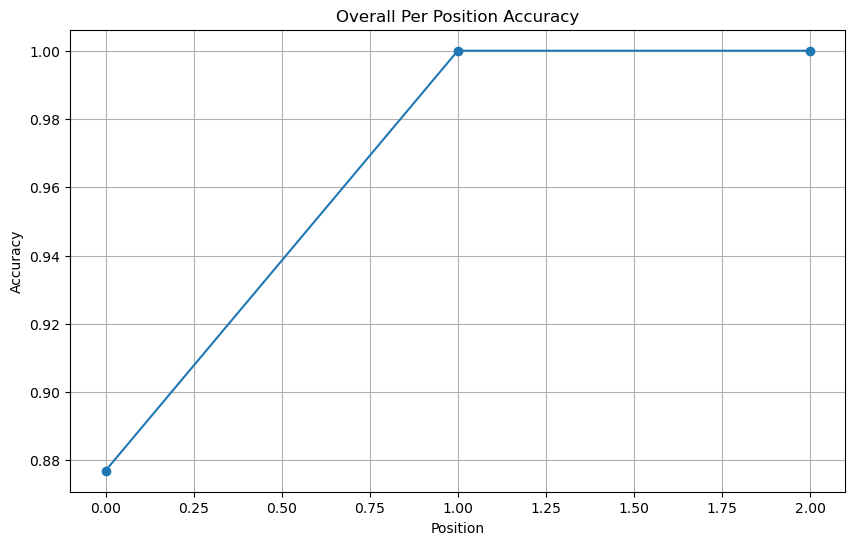

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean         0.958984375
    test_overall_seq_acc              0.876953125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N46 R1 N28 <SEP> N46 R1 N28 <SEP> N8 R2 N26 <SEP> </CTX> <QUERY> N20 R1
Predicted: N28 </QUERY> <EOS>
Target: N39 </QUERY> <EOS>

Input: <CTX> N38 R3 N7 <SEP> N2 R4 N42 <SEP> N18 R3 N26 <SEP> </CTX> <QUERY> N30 R3
Predicted: N23 </QUERY> <EOS>
Target: N40 </QUERY> <EOS>

Input: <CTX> N40 R0 N47 <SEP> N38 R2 N10 <SEP> N0 R2 N47 <SEP> </CTX> <QUERY> N27 R1
Predicted: N5 </QUERY> <EOS>
Target: N19 </QUERY> <EOS>

Input: <CTX> N4 R4 N46 <SEP> N15 R1 N29 <SEP> N8 R1 N3 <SEP>

In [ ]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_1)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map,max_examples=6)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_2)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map, max_examples=6)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_3)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map, max_examples=6)



In [ ]:
def context_extract(dataloader):
    context_tuples_mixture_train =[]
    for x, y in dataloader:
        for i in range(x.size(0)):
            for j in range(x.size(1)):
                if x[i,j] == vocab_map['<CTX>']:
                    context_tuples_mixture_train.append(x[i,j+1: j+4])
                elif x[i,j] == vocab_map['<SEP>'] and x[i,j+1] != vocab_map['</CTX>']:    
                    context_tuples_mixture_train.append(x[i,j+1: j+4])
                elif x[i,j] == vocab_map['</CTX>']:
                    break
    return context_tuples_mixture_train

def query_extract(dataloader):
    query_tuples_mixture_train =[]
    for x, y in dataloader:
        for i in range(x.size(0)):
            for j in range(x.size(1)):
                if x[i,j] == vocab_map['<QUERY>']:
                    query_tuples_mixture_train.append(x[i,j+1: j+4])
                    break
    return query_tuples_mixture_train

    
#print(context_extract(train_dl))

def context_affected_prediction(lit_model,context_tuples_mixture_train, query_tuples_mixture_train):
    
    if not lit_model.mismatched_sequences:
        return None
    counter_own_context = 0
    counter_other_context = 0
    counter_query = 0
    counter_query_ro = 0
    for mismatch in lit_model.mismatched_sequences:
        input_seq = mismatch['input']
        predicted_seq = mismatch['predicted']
        target_seq = mismatch['target']
        
        # find the object and relation in the input sequence
        context_examples = []
        for i in range(len(input_seq)):
            # organize examples from context
            if input_seq[i] == vocab_map['<CTX>']:
                context_examples.append(input_seq[i+1:i+4])
            elif input_seq[i] == vocab_map['<SEP>'] and input_seq[i] != vocab_map['</CTX>']:
                context_examples.append(input_seq[i+1:i+4])
                


            elif input_seq[i] == vocab_map['<QUERY>']:
                sub = input_seq[i+1]
                rel = input_seq[i+2]
                obj_target = target_seq[0]
                obj_pred = predicted_seq[0]
                if (sub, rel, obj_pred) in context_tuples_mixture_train:
                    #print("affected by some context in mixture training",sub, rel, obj_pred)
                    counter_other_context+=1
                
                for (s,r,o) in context_examples:
                    if (r == rel) and (o == obj_pred):
                    #print("affected by its own context",input_seq)   
                        counter_own_context+=1
                        break

                if (sub, rel, obj_pred) in query_tuples_mixture_train:
                    counter_query+=1

                for (s,r,o) in query_tuples_mixture_train:
                    if (r == rel) and (o == obj_pred):
                        counter_query_ro +=1
                        break
                break
        num_mistakes = len(lit_model.mismatched_sequences)
    return counter_own_context/num_mistakes, counter_other_context/num_mistakes, counter_query/num_mistakes, counter_query_ro/num_mistakes

context_tuples_mixture_train = context_extract(train_dl)
query_tuples_mixture_train = query_extract(train_dl)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |          | 0/? [00:00<?, ?it/s]

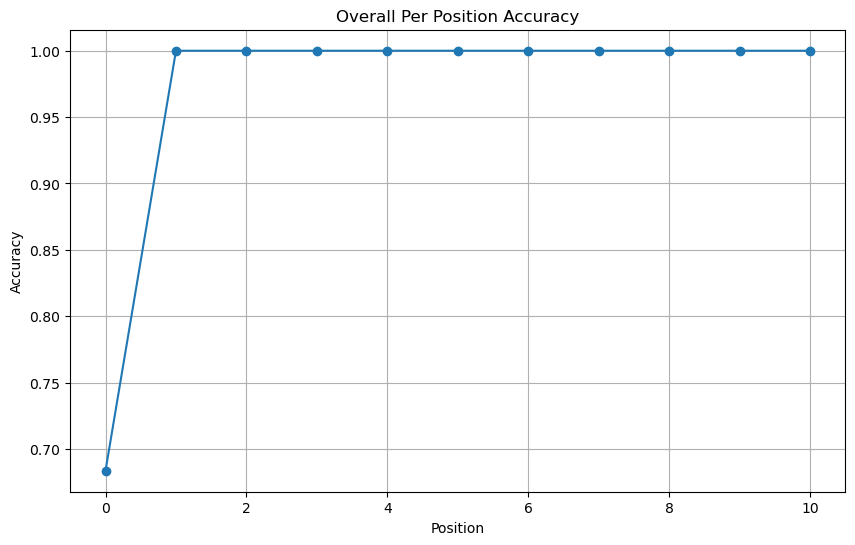

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9712358117103577
    test_overall_seq_acc              0.68359375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


(0.0, 0.0, 0.0, 0.9968253968253968)


Testing: |          | 0/? [00:00<?, ?it/s]

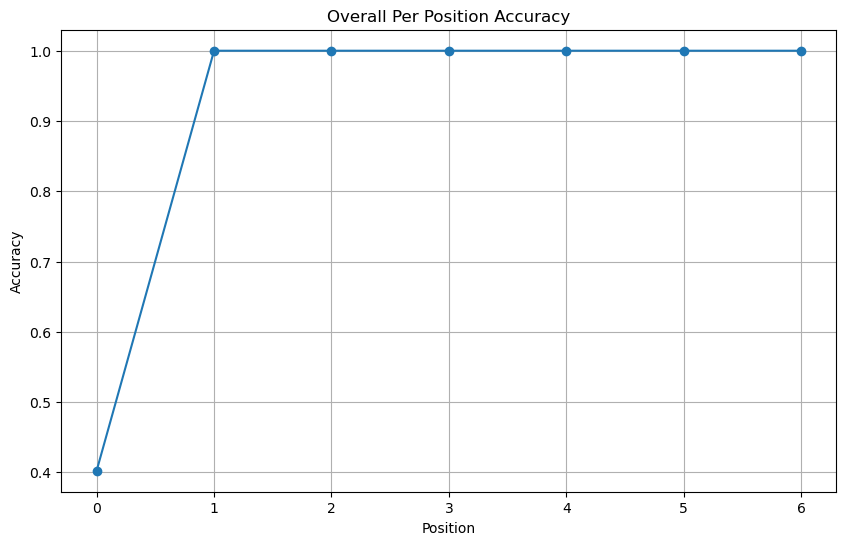

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean      0.914620578289032
    test_overall_seq_acc              0.40234375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


(0.024752475247524754, 0.0, 0.0, 0.9983498349834984)


Testing: |          | 0/? [00:00<?, ?it/s]

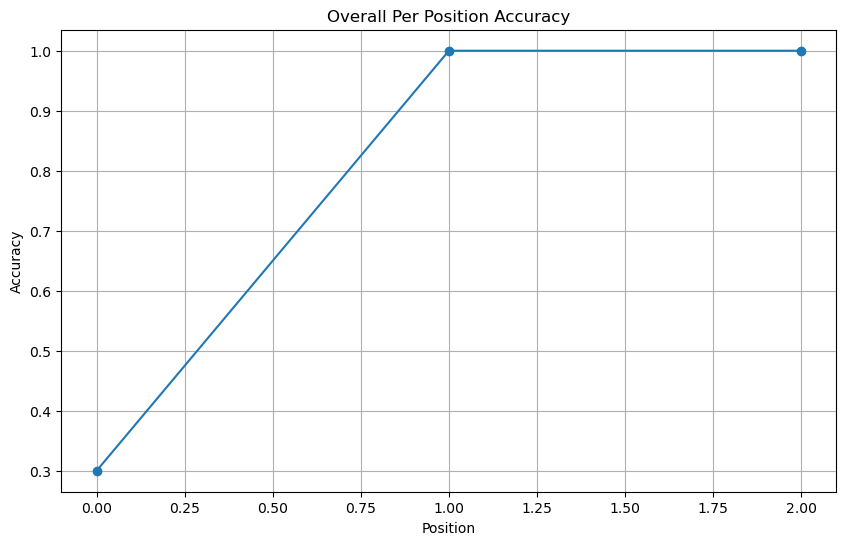

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.7669271230697632
    test_overall_seq_acc              0.30078125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


(0.05991440798858773, 0.0, 0.0, 1.0)


Testing: |          | 0/? [00:00<?, ?it/s]

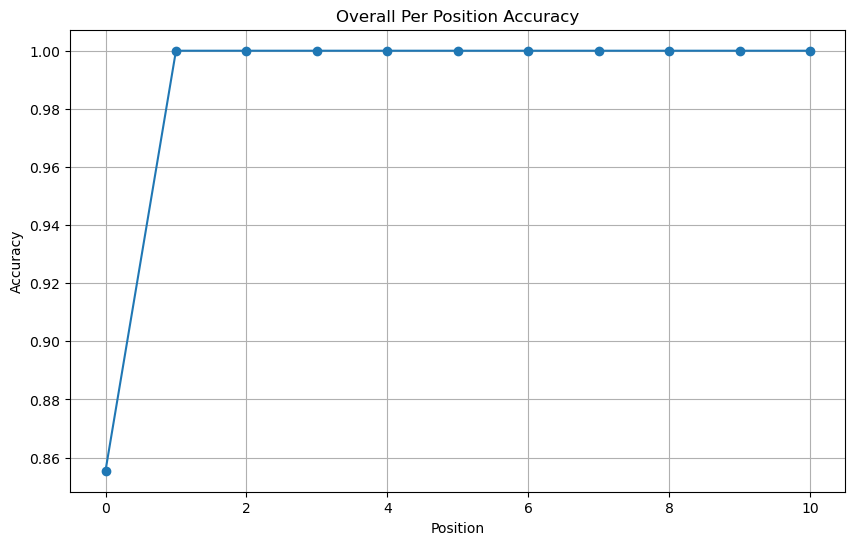

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9868608117103577
    test_overall_seq_acc              0.85546875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


(0.3793103448275862, 0.0, 0.0, 1.0)


Testing: |          | 0/? [00:00<?, ?it/s]

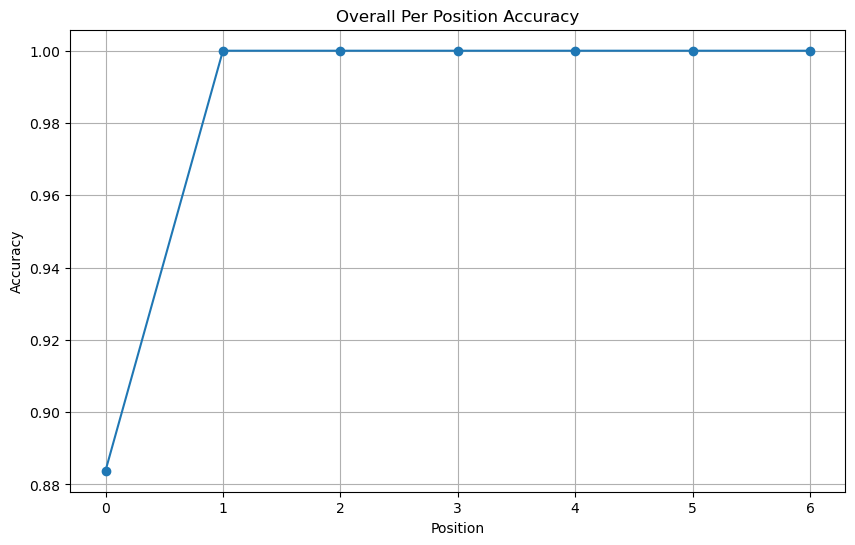

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9833984971046448
    test_overall_seq_acc             0.8837890625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


(0.44537815126050423, 0.0, 0.0, 1.0)


Testing: |          | 0/? [00:00<?, ?it/s]

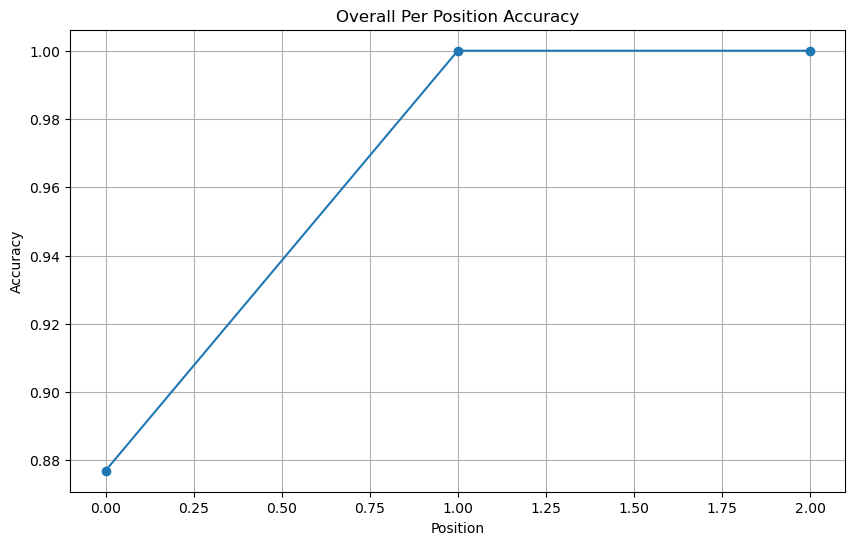

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean         0.958984375
    test_overall_seq_acc              0.876953125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
(0.34146341463414637, 0.0, 0.0, 1.0)


In [ ]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_1)
print("own_context_ro", "other_context_train_dl_sro", "train_dl_query_sro", "train_dl_query_ro", 'fact')
print(context_affected_prediction(lit_model, context_tuples_mixture_train, query_tuples_mixture_train))
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_2)
print("own_context_ro", "other_context_train_dl_sro", "train_dl_query_sro", "train_dl_query_ro", 'fact')
print(context_affected_prediction(lit_model, context_tuples_mixture_train, query_tuples_mixture_train))
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_3)
print("own_context_ro", "other_context_train_dl_sro", "train_dl_query_sro", "train_dl_query_ro", 'fact')
print(context_affected_prediction(lit_model, context_tuples_mixture_train, query_tuples_mixture_train))

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_1)
print("own_context_ro", "other_context_train_dl_sro", "train_dl_query_sro", "train_dl_query_ro", 'fact')
print(context_affected_prediction(lit_model, context_tuples_mixture_train, query_tuples_mixture_train))
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_2)
print("own_context_ro", "other_context_train_dl_sro", "train_dl_query_sro", "train_dl_query_ro", 'fact')
print(context_affected_prediction(lit_model, context_tuples_mixture_train, query_tuples_mixture_train))
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_3)
print("own_context_ro", "other_context_train_dl_sro", "train_dl_query_sro", "train_dl_query_ro", 'fact')
print(context_affected_prediction(lit_model, context_tuples_mixture_train, query_tuples_mixture_train))